In [191]:
using Pkg
Pkg.activate("..")

  Activating project at `~/PhD/MatrixProductBP.jl`


In [192]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, TensorTrains, SparseArrays
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using SparseArrays
using Plots

In [193]:
seed = 2
rng = MersenneTwister(seed)

T = 10
N = 50
gg = uniform_tree(N; rng)
g = IndexedGraph(gg)

β = 1.0
J = 0.7
h = 0.2*0.7
m⁰ = 0.7
K = 30
σ = 1/60

;

In [194]:
connected_components(gg)

1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

In [195]:
ϕᵢ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]
ϕ = fill(ϕᵢ, nv(g))

ising = Ising(g, fill(J,ne(g)), fill(h, nv(g)), β)
bp = Glauber(ising, T; ϕ) |> mpbp

g_ = IndexedBiDiGraph(gg)
w_fourier = [fill(GlauberFactor(fill(J,length(inedges(g,i))), h, β), T+1) for i in vertices(g)]
bp_fourier = mpbp(ComplexF64, g_, w_fourier, fill(2, nv(g)), T; ϕ)
;

In [196]:
matrix_sizes = [5, 10, 15]
maxiters = [5, 5, 0]
iters = zeros(Int, length(maxiters))
tol = 1e-16

for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), tol)
end

Running MPBP: iter 2    Time: 0:00:00

Running MPBP: iter 3    Time: 0:00:01

Running MPBP: iter 4    Time: 0:00:02

Running MPBP: iter 2    Time: 0:00:10

Running MPBP: iter 3    Time: 0:00:17

Running MPBP: iter 4    Time: 0:00:24

Running MPBP: iter 5    Time: 0:00:31

In [197]:
iters_fourier = zeros(Int, length(maxiters))
for i in eachindex(maxiters)
    iters_fourier[i], cb_fourier = iterate_fourier!(bp_fourier, K, maxiter=maxiters[i], σ; svd_trunc=TruncBond(matrix_sizes[i]), tol)
end

Running MPBP: iter 2    Time: 0:00:09

Running MPBP: iter 3    Time: 0:00:19

Running MPBP: iter 4    Time: 0:00:30

Running MPBP: iter 2    Time: 0:03:03

Running MPBP: iter 3    Time: 0:04:59

Running MPBP: iter 4    Time: 0:06:53

Running MPBP: iter 5    Time: 0:08:47

In [198]:
nsamples = 10^6
sms = SoftMarginSampler(bp)
sample!(sms, nsamples);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:01:36


In [199]:
m = means(potts2spin, bp)
m_fourier = real.(means(potts2spin, bp_fourier))
traj_mc = [[vec(potts2spin.(X[i,:])) for X in sms.X] for i in 1:N]
m_mc = [mean(x) for x in traj_mc]
σ_mc = [std(x)/sqrt(nsamples) for x in traj_mc]
;

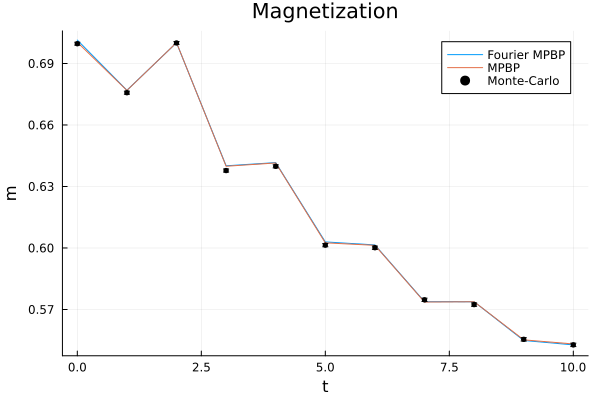

In [231]:
i = 30
y_mc = m_mc[i]
y = m[i]
y_fourier = m_fourier[i]

pl = plot(xlabel="t", ylabel="m", title="Magnetization", legend=:topright)
plot!(pl, 0:T, y_fourier[1:end], label="Fourier MPBP")
plot!(pl, 0:T, y[1:end], label="MPBP")
plot!(pl, 0:T, y_mc[1:end], yerr=σ_mc[i], c=:black, st=:scatter, marker=:dot, markersize=3, label="Monte-Carlo")
display(pl)

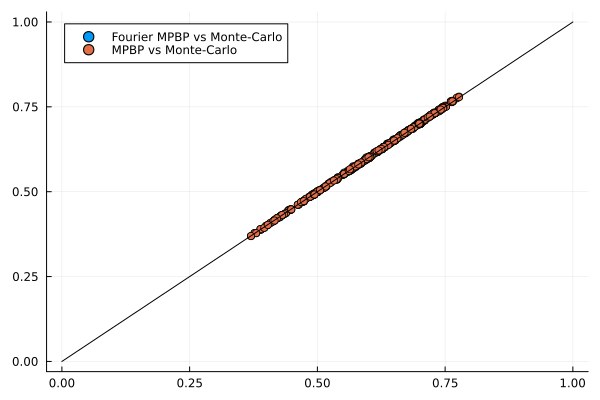

In [201]:
y_sc = reduce(vcat, y[1:2:end] for y in m)
y_fourier_sc = reduce(vcat, y[1:2:end] for y in m_fourier)
y_mc_sc = reduce(vcat, y[1:2:end] for y in m_mc)
pl2 = plot()
plot!(pl2, y_mc_sc, y_fourier_sc, st=:scatter, label="Fourier MPBP vs Monte-Carlo")
plot!(pl2, y_mc_sc, y_sc, st=:scatter, markerstrokecolor=:black, label="MPBP vs Monte-Carlo")
plot!(pl2, 0:0.1:1, 0:0.1:1, c=:black, label="")